In [1]:
import cv2
import matplotlib as mpl
mpl.use('Agg')
import numpy as np
from keras.preprocessing import image

def load_image(image_path, grayscale=False, target_size=None):
    pil_image = image.load_img(image_path, grayscale, target_size)
    return image.img_to_array(pil_image)

def load_detection_model(model_path):
    detection_model = cv2.CascadeClassifier(model_path)
    return detection_model

def detect_faces(detection_model, gray_image_array):
    return detection_model.detectMultiScale(gray_image_array, 1.3, 5)

def draw_bounding_box(face_coordinates, image_array, color):
    x, y, w, h = face_coordinates
    cv2.rectangle(image_array, (x, y), (x + w, y + h), color, 2)

def apply_offsets(face_coordinates, offsets):
    x, y, width, height = face_coordinates
    x_off, y_off = offsets
    return (x - x_off, x + width + x_off, y - y_off, y + height + y_off)

def draw_text(coordinates, image_array, text, color, x_offset=0, y_offset=0,
                                                font_scale=2, thickness=2):
    x, y = coordinates[:2]
    cv2.putText(image_array, text, (x + x_offset, y + y_offset),
                cv2.FONT_HERSHEY_SIMPLEX,
                font_scale, color, thickness, cv2.LINE_AA)

def get_colors(num_classes):
    colors = mpl.pyplot.cm.hsv(np.linspace(0, 1, num_classes)).tolist()
    colors = np.asarray(colors) * 255
    return colors

Using TensorFlow backend.


In [2]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
from random import shuffle
import os
import cv2

class DataManager(object):
    """Class for loading fer2013 emotion classification dataset or
        imdb gender classification dataset."""
    def __init__(self, dataset_name='imdb', dataset_path=None, image_size=(48, 48)):

        self.dataset_name = dataset_name
        self.dataset_path = dataset_path
        self.image_size = image_size
        if self.dataset_path != None:
            self.dataset_path = dataset_path
        elif self.dataset_name == 'imdb':
            self.dataset_path = '../datasets/imdb_crop/imdb.mat'
        elif self.dataset_name == 'fer2013':
            self.dataset_path = '/Users/paul/Projects/RageAnalyticsNetworkTests/Engine/datasets/fer2013/fer2013.csv'
        elif self.dataset_name == 'KDEF':
            self.dataset_path = '../datasets/KDEF/'
        else:
            raise Exception('Incorrect dataset name, please input imdb or fer2013')

    def get_data(self):
        if self.dataset_name == 'imdb':
            ground_truth_data = self._load_imdb()
        elif self.dataset_name == 'fer2013':
            ground_truth_data = self._load_fer2013()
        elif self.dataset_name == 'KDEF':
            ground_truth_data = self._load_KDEF()
        return ground_truth_data

    def _load_imdb(self):
        face_score_treshold = 3
        dataset = loadmat(self.dataset_path)
        image_names_array = dataset['imdb']['full_path'][0, 0][0]
        gender_classes = dataset['imdb']['gender'][0, 0][0]
        face_score = dataset['imdb']['face_score'][0, 0][0]
        second_face_score = dataset['imdb']['second_face_score'][0, 0][0]
        face_score_mask = face_score > face_score_treshold
        second_face_score_mask = np.isnan(second_face_score)
        unknown_gender_mask = np.logical_not(np.isnan(gender_classes))
        mask = np.logical_and(face_score_mask, second_face_score_mask)
        mask = np.logical_and(mask, unknown_gender_mask)
        image_names_array = image_names_array[mask]
        gender_classes = gender_classes[mask].tolist()
        image_names = []
        for image_name_arg in range(image_names_array.shape[0]):
            image_name = image_names_array[image_name_arg][0]
            image_names.append(image_name)
        return dict(zip(image_names, gender_classes))

    def _load_fer2013(self):
        data = pd.read_csv(self.dataset_path)
        pixels = data['pixels'].tolist()
        width, height = 48, 48
        faces = []
        for pixel_sequence in pixels:
            face = [int(pixel) for pixel in pixel_sequence.split(' ')]
            face = np.asarray(face).reshape(width, height)
            face = cv2.resize(face.astype('uint8'), self.image_size)
            faces.append(face.astype('float32'))
        faces = np.asarray(faces)
        faces = np.expand_dims(faces, -1)
        emotions = pd.get_dummies(data['emotion']).as_matrix()
        return faces, emotions

    def _load_KDEF(self):
        class_to_arg = get_class_to_arg(self.dataset_name)
        num_classes = len(class_to_arg)

        file_paths = []
        for folder, subfolders, filenames in os.walk(self.dataset_path):
            for filename in filenames:
                if filename.lower().endswith(('.jpg')):
                    file_paths.append(os.path.join(folder, filename))

        num_faces = len(file_paths)
        y_size, x_size = self.image_size
        faces = np.zeros(shape=(num_faces, y_size, x_size))
        emotions = np.zeros(shape=(num_faces, num_classes))
        for file_arg, file_path in enumerate(file_paths):
            image_array = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            image_array = cv2.resize(image_array, (y_size, x_size))
            faces[file_arg] = image_array
            file_basename = os.path.basename(file_path)
            file_emotion = file_basename[4:6]
            # there are two file names in the dataset that don't match the given classes
            try:
                emotion_arg = class_to_arg[file_emotion]
            except:
                continue
            emotions[file_arg, emotion_arg] = 1
        faces = np.expand_dims(faces, -1)
        return faces, emotions

def get_labels(dataset_name):
    if dataset_name == 'fer2013':
        return {0:'angry',1:'disgust',2:'fear',3:'happy',
                4:'sad',5:'surprise',6:'neutral'}
    elif dataset_name == 'imdb':
        return {0:'woman', 1:'man'}
    elif dataset_name == 'KDEF':
        return {0:'AN', 1:'DI', 2:'AF', 3:'HA', 4:'SA', 5:'SU', 6:'NE'}
    else:
        raise Exception('Invalid dataset name')

def get_class_to_arg(dataset_name='fer2013'):
    if dataset_name == 'fer2013':
        return {'angry':0, 'disgust':1, 'fear':2, 'happy':3, 'sad':4,
                'surprise':5, 'neutral':6}
    elif dataset_name == 'imdb':
        return {'woman':0, 'man':1}
    elif dataset_name == 'KDEF':
        return {'AN':0, 'DI':1, 'AF':2, 'HA':3, 'SA':4, 'SU':5, 'NE':6}
    else:
        raise Exception('Invalid dataset name')

def split_imdb_data(ground_truth_data, validation_split=.2, do_shuffle=False):
    ground_truth_keys = sorted(ground_truth_data.keys())
    if do_shuffle == True:
        shuffle(ground_truth_keys)
    training_split = 1 - validation_split
    num_train = int(training_split * len(ground_truth_keys))
    train_keys = ground_truth_keys[:num_train]
    validation_keys = ground_truth_keys[num_train:]
    return train_keys, validation_keys

def split_data(x, y, validation_split=.2):
    num_samples = len(x)
    num_train_samples = int((1 - validation_split)*num_samples)
    train_x = x[:num_train_samples]
    train_y = y[:num_train_samples]
    val_x = x[num_train_samples:]
    val_y = y[num_train_samples:]
    train_data = (train_x, train_y)
    val_data = (val_x, val_y)
    return train_data, val_data



In [3]:
import numpy as np
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import numpy.ma as ma
import cv2
# from Engine.utils.inference import draw_text

def make_mosaic(images, num_rows, num_cols, border=1, class_names=None):
    num_images = len(images)
    image_shape = images.shape[1:]
    mosaic = ma.masked_all((num_rows * image_shape[0] + (num_rows - 1) * border,
                            num_cols * image_shape[1] + (num_cols - 1) * border),
                            dtype=np.float32)
    paddedh = image_shape[0] + border
    paddedw = image_shape[1] + border
    for image_arg in range(num_images):
        row = int(np.floor(image_arg / num_cols))
        col = image_arg % num_cols
        image = np.squeeze(images[image_arg])
        image_shape = image.shape
        mosaic[row * paddedh:row * paddedh + image_shape[0],
               col * paddedw:col * paddedw + image_shape[1]] = image
    return mosaic

def make_mosaic_v2(images, num_mosaic_rows=None,
                num_mosaic_cols=None, border=1):
    images = np.squeeze(images)
    num_images, image_pixels_rows, image_pixels_cols = images.shape
    if num_mosaic_rows is None and num_mosaic_cols is None:
        box_size = int(np.ceil(np.sqrt(num_images)))
        num_mosaic_rows = num_mosaic_cols = box_size
    num_mosaic_pixel_rows = num_mosaic_rows * (image_pixels_rows + border)
    num_mosaic_pixel_cols = num_mosaic_cols * (image_pixels_cols + border)
    mosaic = np.empty(shape=(num_mosaic_pixel_rows, num_mosaic_pixel_cols))
    mosaic_col_arg = 0
    mosaic_row_arg = 0
    for image_arg in range(num_images):
        if image_arg % num_mosaic_cols == 0 and image_arg != 0:
            mosaic_col_arg = mosaic_col_arg + 1
            mosaic_row_arg = 0
        x0 = image_pixels_cols * (mosaic_row_arg)
        x1 = image_pixels_cols * (mosaic_row_arg + 1)
        y0 = image_pixels_rows * (mosaic_col_arg)
        y1 = image_pixels_rows * (mosaic_col_arg + 1)
        image = images[image_arg]
        mosaic[y0:y1, x0:x1] = image
        mosaic_row_arg = mosaic_row_arg + 1
    return mosaic

def pretty_imshow(axis, data, vmin=None, vmax=None, cmap=None):
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    cax = None
    divider = make_axes_locatable(axis)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    image = axis.imshow(data, vmin=vmin, vmax=vmax,
                        interpolation='nearest', cmap=cmap)
    plt.colorbar(image, cax=cax)

def normal_imshow(axis, data, vmin=None, vmax=None,
                        cmap=None, axis_off=True):
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    image = axis.imshow(data, vmin=vmin, vmax=vmax,
                        interpolation='nearest', cmap=cmap)
    if axis_off:
        plt.axis('off')
    return image

def display_image(face, class_vector=None,
                    class_decoder=None, pretty=False):
    if class_vector is not None and class_decoder is None:
        raise Exception('Provide class decoder')
    face = np.squeeze(face)
    color_map = None
    if len(face.shape) < 3:
        color_map = 'gray'
    plt.figure()
    if class_vector is not None:
        class_arg = np.argmax(class_vector)
        class_name = class_decoder[class_arg]
        plt.title(class_name)
    if pretty:
        pretty_imshow(plt.gca(), face, cmap=color_map)
    else:
        plt.imshow(face, color_map)

def draw_mosaic(data, num_rows, num_cols, class_vectors=None,
                            class_decoder=None, cmap='gray'):

    if class_vectors is not None and class_decoder is None:
        raise Exception('Provide class decoder')

    figure, axis_array = plt.subplots(num_rows, num_cols)
    figure.set_size_inches(8, 8, forward=True)
    titles = []
    if class_vectors is not None:
        for vector_arg in range(len(class_vectors)):
            class_arg = np.argmax(class_vectors[vector_arg])
            class_name = class_decoder[class_arg]
            titles.append(class_name)

    image_arg = 0
    for row_arg in range(num_rows):
        for col_arg in range(num_cols):
            image = data[image_arg]
            image = np.squeeze(image)
            axis_array[row_arg, col_arg].axis('off')
            axis_array[row_arg, col_arg].imshow(image, cmap=cmap)
            axis_array[row_arg, col_arg].set_title(titles[image_arg])
            image_arg = image_arg + 1
    plt.tight_layout()

In [3]:
#from utils.data_manager import DataManager
#from Engine.utils.datasets import get_labels
from keras.models import load_model
#from Engine.utils.datasets import DataManager
import pickle

In [6]:
#dataset_name = 'fer2013'
#model_path = '../trained_models/emotion_models/simple_CNN.985-0.66.hdf5'
dataset_name = 'fer2013'
class_decoder = get_labels(dataset_name)
data_manager = DataManager(dataset_name)
faces, emotions = data_manager.get_data()
#faces = pickle.load(open('faces.pkl', 'rb'))
#emotions = pickle.load(open('emotions.pkl', 'rb'))
# pretty_imshow(plt.gca(), make_mosaic(faces[:4], 2, 2), cmap='gray')
# plt.show()

In [8]:
import numpy as np
from scipy.misc import imread, imresize


def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x

def _imread(image_name):
        return imread(image_name)

def _imresize(image_array, size):
        return imresize(image_array, size)

def to_categorical(integer_classes, num_classes=2):
    integer_classes = np.asarray(integer_classes, dtype='int')
    num_samples = integer_classes.shape[0]
    categorical = np.zeros((num_samples, num_classes))
    categorical[np.arange(num_samples), integer_classes] = 1
    return categorical





In [10]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import cv2
from keras.models import load_model

#from Engine.utils.datasets import get_labels
#from Engine.utils.inference import detect_faces
#from Engine.utils.preprocessor import preprocess_input
#from Engine.utils.video_transformation import trim_frame
#from Engine.streaming_util.streaming_handler import create_new_streaming_file

def plot_convolution_matrix_of_model(emotion_model_path):
    
    class_names = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    
    y_test_raw = emotions[:2000]
    x_test = faces[:2000]
    
    emotion_classifier = load_model(emotion_model_path, compile=False)
    
    # getting input model shapes for inference
    emotion_target_size = emotion_classifier.input_shape[1:3]
    
    y_pred = []
    y_test = []
    
    for i in range(len(y_test_raw)):
        gray_face = cv2.resize(x_test[i], (emotion_target_size))
        gray_face = preprocess_input(gray_face, True)
        gray_face = np.expand_dims(gray_face, 0)
        gray_face = np.expand_dims(gray_face, -1)
        emotion_prediction = emotion_classifier.predict(gray_face)
        pred_label = np.argmax(emotion_prediction)
        
        # print("pred: "+str(emotion_prediction))
        
        index = int(list(y_test_raw[i]).index(1))
        y_test.append(class_names[index])
        y_pred.append(class_names[pred_label])
    
    def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            # print("Normalized confusion matrix")
        else:
            print("")
            # print('Confusion matrix, without normalization')
    
        # print(cm)
    
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
    
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')
    
    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')
    
    plt.show()

### Confusion Matrix of mini_XCEPTION.102-0.66:

In [10]:
emotion_model_path = '/Users/danieltremer/Documents/GIT-Repositories/rage-analytics/Engine/trained_models/emotion_models/fer2013_mini_XCEPTION.102-0.66.hdf5'

plot_convolution_matrix_of_model(emotion_model_path)

OSError: Unable to open file (Unable to open file: name = '/users/danieltremer/documents/git-repositories/rage-analytics/engine/trained_models/emotion_models/fer2013_mini_xception.102-0.66.hdf5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

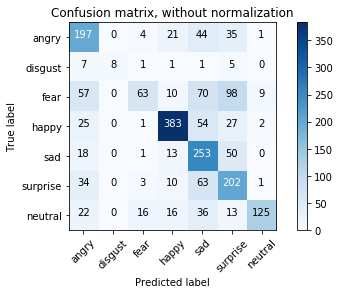

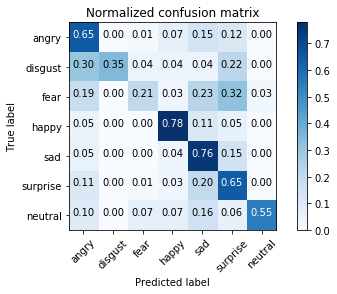

In [43]:
emotion_model_path = '/Users/danieltremer/Documents/GIT-Repositories/rage-analytics/Engine/trained_models/emotion_models/simple_CNN.985-0.66.hdf5'

plot_convolution_matrix_of_model(emotion_model_path)

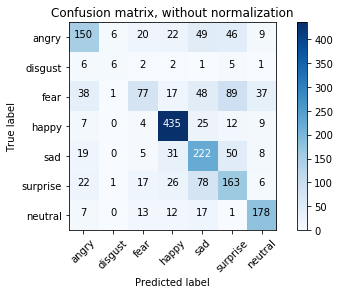

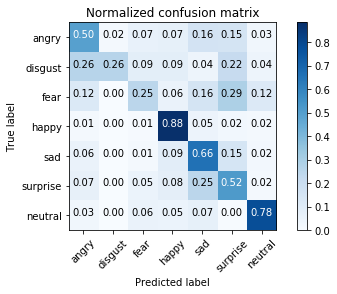

In [44]:
emotion_model_path = '/Users/danieltremer/Documents/GIT-Repositories/rage-analytics/Engine/trained_models/emotion_models/fer2013_simple_CNN.255-0.61.hdf5'

plot_convolution_matrix_of_model(emotion_model_path)

In [12]:
# YOLO!

emotion_model_path = '/Users/paul/Projects/rageanalytics/engine/Engine/trained_models/emotion_models/fer2013_mini_XCEPTION.102-0.66.hdf5'

plot_convolution_matrix_of_model(emotion_model_path)

In [16]:
model = load_model('/Users/danieltremer/Documents/GIT-Repositories/rage-analytics/Engine/trained_models/emotion_models/simple_CNN.985-0.66.hdf5')
conv1_weights = model.layers[2].get_weights()
kernel_conv1_weights = conv1_weights[0]
kernel_conv1_weights = np.squeeze(kernel_conv1_weights)
kernel_conv1_weights = np.rollaxis(kernel_conv1_weights, 2, 0)
kernel_conv1_weights = np.expand_dims(kernel_conv1_weights, -1)
num_kernels = kernel_conv1_weights.shape[0]
box_size = int(np.ceil(np.sqrt(num_kernels)))
print('Box size:', box_size)

print('Kernel shape', kernel_conv1_weights.shape)
plt.figure(figsize=(15, 15))
plt.title('conv1 weights')
pretty_imshow(plt.gca(),
        make_mosaic(kernel_conv1_weights, box_size, box_size),
        cmap=cm.binary)
plt.show()

ValueError: 'axis' arg requires -1 <= axis < 1, but 2 was passed in